# Model Reduction on a Linear SDE

In [1]:
include("modgen_LSDE.jl")
include("..\\..\\Tools\\Model_Reduction_Dev.jl")

vector_wiener_filter_fft

In [2]:
using JLD
using PyPlot
using DSP: nextfastfft

the model is
$$dX_t = AX_tdt + \sigma dW_t$$
my implementation of Euler-Maruyama produces
$$ X_{n+1} = (1 + hA)X_n + \sqrt{h}\sigma u_n \qquad \text{where }u_n \sim N(0,1)$$

## Generate the data 

In [3]:
A = reshape([-0.5],1,1)
σ = reshape([1],1,1)
Xo = [1]
t_disc = 1000
gap = 1
scheme = "EM"

t_start = 0
t_stop  = 1e5
h       = 1e-2

Δt      = h*gap
M_out   = 20

X = modgen_LSDE(t_start,t_stop,h,
    A = A,
    σ = σ,
    Xo = Xo,
    t_disc = t_disc,
    gap = gap,
    scheme = scheme)

d, N = size(X)

nfft = nextfastfft(N)
X = [X zeros(d,nfft-N)]


τ_exp, τ_int    = auto_times(X[:])*Δt
N_eff           = N*Δt/τ_int

Psi(x) = x

Psi (generic function with 1 method)

In [4]:
@time h_wf = get_wf(X, Psi, par = 2000);
X = X[:,1:N]

Number of CKMS iterations: 980
errK errR : 2.6111004081224627e-11 5.386992398075367e-16
 50.368920 seconds (524.99 M allocations: 26.345 GiB, 10.80% gc time)


1×9900001 Array{Float64,2}:
 0.290761  0.299407  0.391377  0.474412  …  -0.555082  -0.507017  -0.542111

In [5]:
(τ_exp, N_eff)

(1.9941733720085884, 50067.3040042568)

In [6]:
1 .+ h*A

1×1 Array{Float64,2}:
 0.995

In [7]:
h_wf

1×1×20 Array{Float64,3}:
[:, :, 1] =
 0.9953233294463933

[:, :, 2] =
 -0.00020919004589103283

[:, :, 3] =
 -0.00024203960050139507

...

[:, :, 18] =
 -0.0003234461200461408

[:, :, 19] =
 5.553214528984618e-5

[:, :, 20] =
 -0.00010097015574818532

## Get reduced (reproduced) model (no noise) 

In [8]:
# d, N  = size(X)
# nu    = size(Psi(X[:,1]),1) 
# M_out = size(h_wf,3)

# X_rm = zeros(d,N); X_rm[:,1:M_out] = X[:,1:M_out]

# PSI = zeros(nu,N); 
# for i = 1:M_out
#     PSI[:,i] = Psi(X_rm[:,i])
# end

# for i = M_out + 1 : N
#     X_rm[:,i] = sum(h_wf[:,:,k]*PSI[:,i-k] for k = 1:M_out, dims = 2)
#     PSI[:,i] = Psi(X_rm[:,i])
# end



## Get reduced (reproduced) model with noise

In [8]:
d, N  = size(X)
nu    = size(Psi(X[:,1]),1) 
M_out = 2 #size(h_wf,3)

X_rm = zeros(d,N); X_rm[:,1:M_out] = X[:,1:M_out]

PSI = zeros(nu,N); 
for i = 1:M_out
    PSI[:,i] = Psi(X_rm[:,i])
end

for i = M_out + 1 : N
    X_rm[:,i] = sum(h_wf[:,:,k]*PSI[:,i-k] for k = 1:M_out, dims = 2) + sqrt(h)*σ*randn(d)
    PSI[:,i] = Psi(X_rm[:,i])
end

In [26]:
data = Dict(
        "h_wf" => h_wf,
        "A" => A,
        "σ" => σ,
        "Xo" => Xo,
        "t_disc" => t_disc,
        "gap" => gap,
        "scheme" => scheme,
        "t_start" => t_start,
        "t_stop" => t_start,
        "h" => h,
        "X_55" => X,
        "X__rm_55_h_4" => X_rm)

save("Data\\LSDE_wfs.jld",data)

UndefVarError: UndefVarError: X_rm not defined

In [27]:
data = load("Data\\LSDE_wfs.jld")

Dict{String,Any} with 12 entries:
  "t_disc"       => 1000
  "h"            => 0.01
  "X__rm_55_h_4" => [0.15406 -0.0238143 … -2.61855e-322 -2.61855e-322]
  "t_start"      => 0
  "σ"            => [1]
  "t_stop"       => 0
  "Xo"           => [1]
  "scheme"       => "EM"
  "A"            => [-0.9]
  "h_wf"         => [0.990711]…
  "gap"          => 1
  "X_55"         => [0.15406 -0.0238143 … 0.0 0.0]

In [11]:
blup = findall(isnan,X_rm[1,:])[1]

BoundsError: BoundsError: attempt to access 0-element Array{Int64,1} at index [1]

In [12]:
findall(x -> x > 10^1,X_rm[1,:])[1]

BoundsError: BoundsError: attempt to access 0-element Array{Int64,1} at index [1]

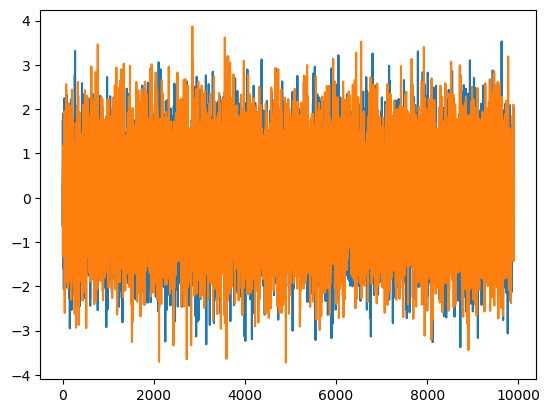

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003AC2C388>
 PyObject <matplotlib.lines.Line2D object at 0x000000003AC39748>

In [13]:
plot([X[1:1000:end] X_rm[1:1000:end]])

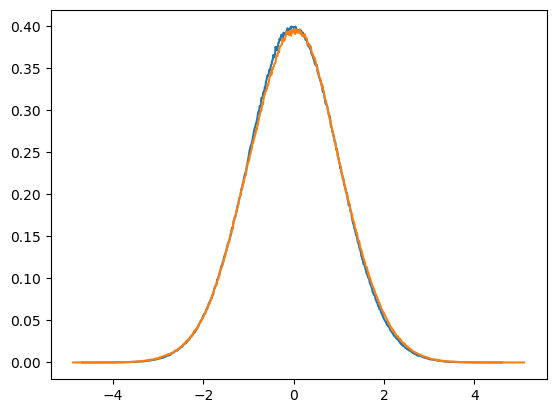

3-element Array{Array{T,1} where T,1}:
 [7.960089133092796e-6, 0.0, 0.0, 0.0, 7.960089133092796e-6, 1.5920178266185593e-5, 7.960089133092798e-6, 7.960089133092793e-6, 7.960089133092793e-6, 0.0  …  0.0, 0.0, 0.0, 1.5920178263758864e-5, 1.5920178263758864e-5, 7.960089136253981e-6, 0.0, 7.960089136253981e-6, 7.960089127504881e-6, 7.960089136253981e-6]                                                                                  
 [-4.8770898630617925, -4.864400295254425, -4.851710727447058, -4.8390211596396915, -4.826331591832325, -4.813642024024958, -4.800952456217591, -4.788262888410225, -4.775573320602858, -4.76288375279549  …  4.982704323262182, 4.99539389106955, 5.008083458876916, 5.0207730266842825, 5.03346259449165, 5.046152162299016, 5.058841730106383, 5.07153129791375, 5.084220865721117, 5.096910433528484]
 PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x00000000476C2BC8>]                                                                                            

In [14]:
emp_pdf(X[1:9900001])
emp_pdf(X_rmn[1:9900001])

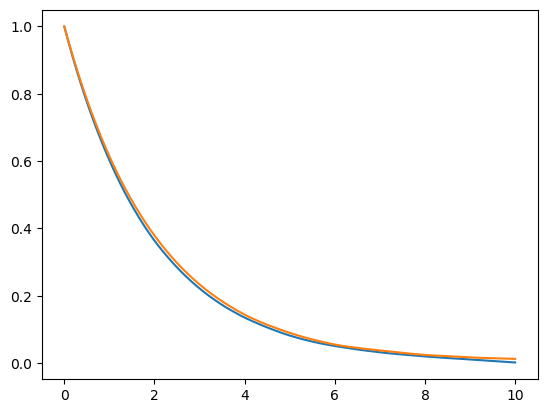

C:\Users\jared\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000047737FC8>
 PyObject <matplotlib.lines.Line2D object at 0x00000000021B3BC8>

In [15]:
lags = 0:1000

A_rm = my_autocor(X_rmn[:],lags)
A    = my_autocor(X[:],lags) 

plot(lags*h,[A A_rm])

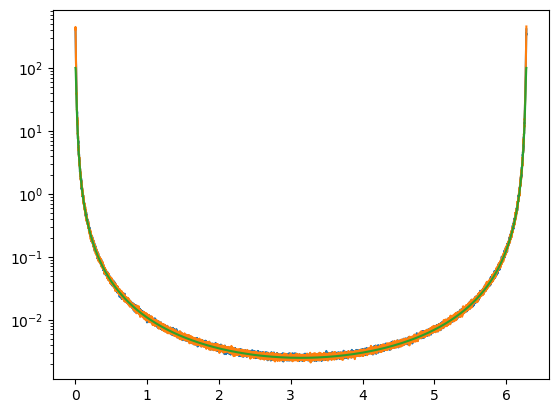

3-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000473E09C8>
 PyObject <matplotlib.lines.Line2D object at 0x00000000473F3148>
 PyObject <matplotlib.lines.Line2D object at 0x00000000473F3308>

In [16]:
z_spect = z_spect_scalar(X[:], n = 3, p=100, ty = "ave")
z_spect_rm = z_spect_scalar(X_rmn[:], n = 3, p=100, ty = "ave")

Θ = 2*π*(1:1000:nfft)/nfft
Z = exp.(im*Θ)

a = 1 + h*A[1,1]
z_spect_ana_fun(z) = h*σ/( (1-a*z^(-1))*(1-a*z) )
z_spect_ana = real(z_spect_ana_fun.(Z))

semilogy(Θ,[z_spect[1:1000:nfft] z_spect_rm[1:1000:nfft] z_spect_ana])